# Exploratory Data Analysis

In [20]:
import json
import os
import datetime
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


data_path = Path("data/")

## Task 1
**Gambling Disorder**: This is a binary classification task aimed at determining whether a user is at high risk (label = 1) or low risk (label = 0) of developing a gambling-related disorder based on their messages. The objective is to enable early detection and facilitate timely interventions. 

### Annotations

In [21]:
annotation_path = data_path / "task1" / "train" / "gold_task1.txt"
df = pd.read_csv(annotation_path)
annotation_users = df.Subject.values
df.head()

labels_df = df.rename(columns={"Subject": "user", "Risk": "label"})
labels_df.head()

,user,label
0,user1036,1
1,user1037,1
2,user1150,1
3,user124,1
4,user1301,1


In [22]:
labels_df.dtypes

user     object
label     int64
dtype: object

In [23]:
print("INFO:")
print(f"INFO: total number of users {len(labels_df)}")
print(f"INFO: positive samples {labels_df.label.sum()}")
print(f"INFO: negative samples {len(labels_df) - labels_df.label.sum()}")
labels_df.describe()

INFO:
INFO: total number of users 350
INFO: positive samples 172
INFO: negative samples 178


,label
count,350.000000
mean,0.491429
std,0.500642
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


### Messages

In [24]:
user_messages_path = data_path / "task1" / "train" / "subjects"
user_messages = list(user_messages_path.glob("*.json"))
print(f"INFO: number of users with found messages {len(user_messages)}")

messages_users = [s.name.replace(".json", "") for s in user_messages]
print(f"INFO: inconsistency between messages users and annotation users: {set(annotation_users) - set(messages_users)}")


INFO: number of users with found messages 350
INFO: inconsistency between messages users and annotation users: set()


In [25]:
with open(user_messages[0], "r") as file:
    messages = json.load(file)


messages_df = pd.DataFrame(messages)
messages_df["date"] = pd.to_datetime(messages_df["date"])
messages_df.set_index("date", inplace=True)
messages_df.head()

,id_message,message,platform
date,,,
2021-04-27 22:30:20+01:00,60951539963,El canal del amigo se llama loco por el trading ?,Telegram
2021-04-28 00:12:59+01:00,16299019771,Hay vivo hoy ?,Telegram
2021-04-29 01:11:42+01:00,34554847765,Eos alguien lo vio ?,Telegram
2021-04-29 02:15:10+01:00,84775152095,A que hora es el vivo ?,Telegram
2021-04-30 03:13:18+01:00,22627629888,No arranca vet,Telegram


In [26]:
all_messages = []
for user_file in user_messages:
    with open(user_file, "r") as file:
        messages = json.load(file)
    
    messages_df = pd.DataFrame(messages)
    messages_df["date"] = pd.to_datetime(messages_df["date"], format="%Y-%m-%d %H:%M:%S%z")
    messages_df["user"] = user_file.name.replace(".json", "")
    all_messages.append(messages_df)

all_messages_df = pd.concat(all_messages, ignore_index=True)
all_messages_df.set_index("date", inplace=True)
print(f"INFO: full dataset shape {labels_df.shape}")

if "platform" in all_messages_df.columns:
    unique_platforms = all_messages_df["platform"].dropna().unique()
    print("INFO: Unique Platforms:", unique_platforms)
else:
    print("No 'platform' column found in dataset.")

nan_summary = all_messages_df.isnull().sum()

print("INFO: Missing Values:")
print(nan_summary)

INFO: full dataset shape (350, 2)
INFO: Unique Platforms: ['Telegram' 'Twitch']
INFO: Missing Values:
id_message    0
message       1
platform      0
user          0
dtype: int64


In [27]:
all_messages_df.tail()

,id_message,message,platform,user
date,,,,
2022-10-08 01:33:29+01:00,82720946231,"Buenas , Hoy hay directo ?",Telegram,user9984
2022-10-08 01:52:36+01:00,79539893868,😈,Telegram,user9984
2022-10-08 02:16:18+01:00,44449300457,Sip,Telegram,user9984
2022-10-08 05:57:06+01:00,45268249237,Jaja si es verdad user 7376 la misma con $ 125...,Telegram,user9984
2022-11-02 19:55:16+01:00,10802100092,Y en cuánto tiempo se estabiliza el mercado ?,Telegram,user9984


INFO: total number of messages 22491
INFO: number of messages per platform platform
Telegram    19573
Twitch       2918
Name: count, dtype: int64


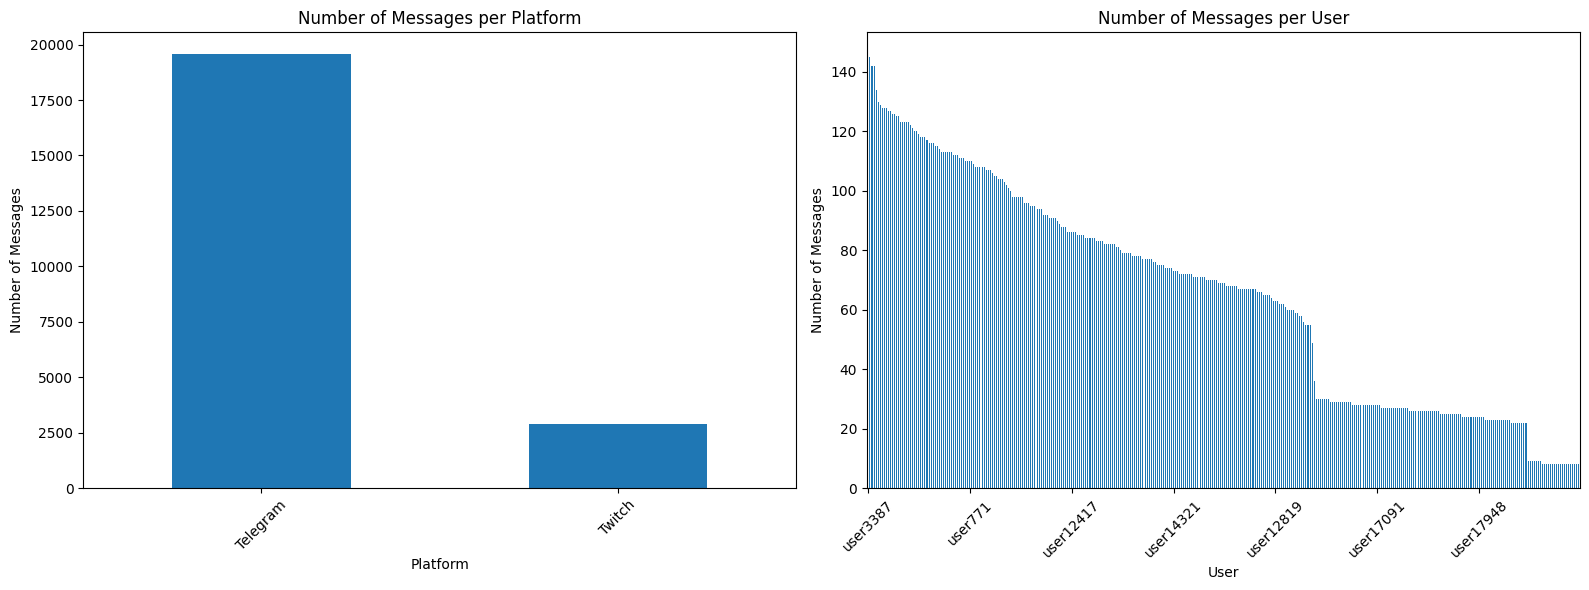

In [28]:
total_messages = len(all_messages_df)
print(f"INFO: total number of messages {total_messages}")
platform_counts = all_messages_df['platform'].value_counts()
print(f"INFO: number of messages per platform {platform_counts}")
user_counts = all_messages_df['user'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))  

platform_counts.plot(kind='bar', ax=axes[0])
axes[0].set_title('Number of Messages per Platform')
axes[0].set_xlabel('Platform')
axes[0].set_ylabel('Number of Messages')
axes[0].tick_params(axis='x', rotation=45)

user_counts.plot(kind='bar', ax=axes[1])
axes[1].set_title('Number of Messages per User')
axes[1].set_xlabel('User')
axes[1].set_ylabel('Number of Messages')
axes[1].tick_params(axis='x', rotation=45) 

N = 50
axes[1].set_xticks(axes[1].get_xticks()[::N])
plt.tight_layout()
plt.show()

1. clear unbalance towards Telegram platform messages
1. Three observed categories of users:
    - messages $<20$
    - $20<$ messages $<60$
    - messages $<60$

In [29]:
merged_df = all_messages_df.merge(labels_df, on="user", how="left")
positives_df = merged_df[merged_df["label"] == 1]
positives_per_platform = positives_df["platform"].value_counts()
positives_per_user = positives_df["user"].value_counts()

print("INFO: Positives per platform:\n", positives_per_platform)

INFO: Positives per platform:
 platform
Telegram    9539
Twitch      1513
Name: count, dtype: int64


In [30]:
# Group messages by user and count the number of messages per user
user_message_counts = all_messages_df.groupby("user").agg(
    num_messages=("message", "count"), platform=("platform", "first")
).reset_index()

# Merge with labels_df to include the label column
merged_df = user_message_counts.merge(labels_df, on="user", how="left")

# Filter only positive labels (label == 1)
positives_df = merged_df[merged_df["label"] == 1]

# Compute number of positives per platform
positives_per_platform = positives_df["platform"].value_counts()

# Compute number of messages per positive user
positives_per_user = positives_df[["user", "num_messages"]]

# Display results
print("Positives per platform:\n", positives_per_platform)
print("\nNumber of messages per positive user:\n", positives_per_user)


Positives per platform:
 platform
Telegram    105
Twitch       67
Name: count, dtype: int64

Number of messages per positive user:
           user  num_messages
2    user10290            74
4    user10343            86
5     user1036           112
6     user1037           125
10   user10654            65
..         ...           ...
305   user7442            75
306   user7455            86
310   user7508            77
314   user7532            80
315   user7535            70

[172 rows x 2 columns]


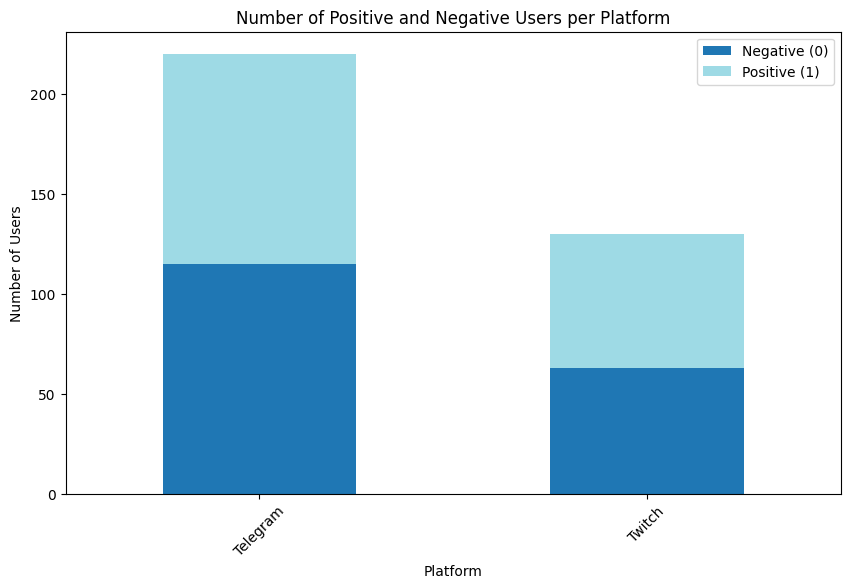

In [31]:
user_message_counts = all_messages_df.groupby("user").agg(
    num_messages=("message", "count"), platform=("platform", "first")
).reset_index()

merged_df = user_message_counts.merge(labels_df, on="user", how="left").fillna(0)

# Count positives and negatives per platform
platform_counts = merged_df.groupby(["platform", "label"]).size().unstack(fill_value=0)

# Plot the histogram
platform_counts.plot(kind="bar", stacked=True, figsize=(10, 6), colormap="tab20")

plt.title("Number of Positive and Negative Users per Platform")
plt.xlabel("Platform")
plt.ylabel("Number of Users")
plt.legend(["Negative (0)", "Positive (1)"])
plt.xticks(rotation=45)
plt.show()

In [32]:
merged_df = all_messages_df.merge(labels_df, on="user", how="left")

merged_df.head()

,id_message,message,platform,user,label
0,60951539963,El canal del amigo se llama loco por el trading ?,Telegram,user10040,0
1,16299019771,Hay vivo hoy ?,Telegram,user10040,0
2,34554847765,Eos alguien lo vio ?,Telegram,user10040,0
3,84775152095,A que hora es el vivo ?,Telegram,user10040,0
4,22627629888,No arranca vet,Telegram,user10040,0


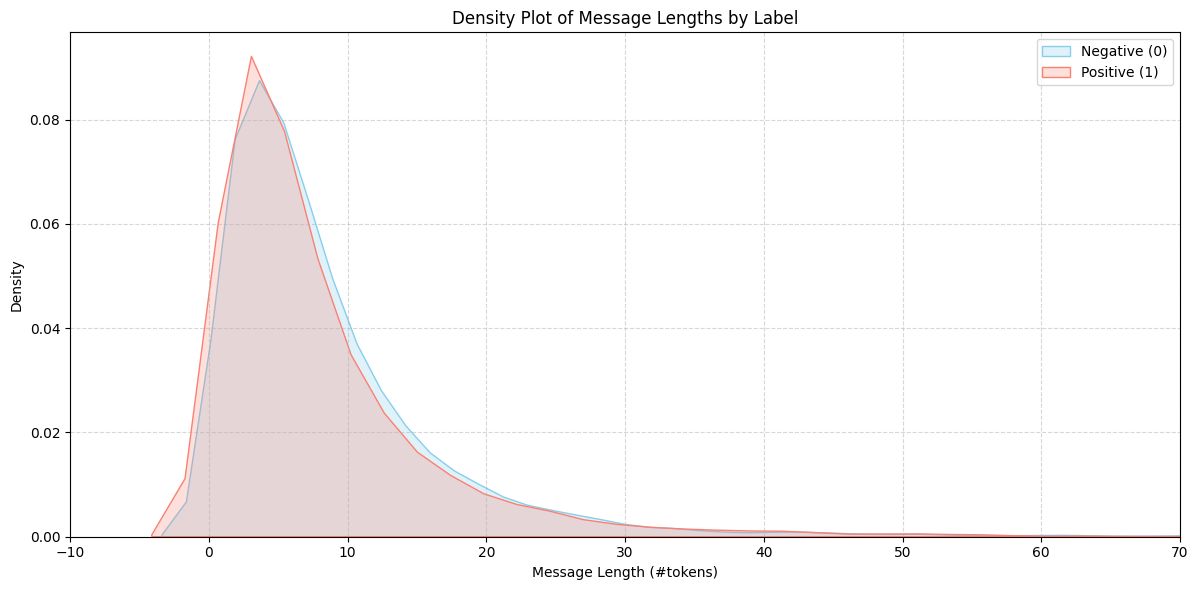

In [33]:
df = merged_df.copy()

# Calculate message lengths
df['message_length'] = df['message'].str.split().str.len()

# Separate data by label
df_0 = df[df['label'] == 0]
df_1 = df[df['label'] == 1]


# Plot the distributions
plt.figure(figsize=(12, 6))
color_0 = 'skyblue'  
color_1 = 'salmon'
sns.kdeplot(df_0['message_length'], fill=True, label='Negative (0)', common_norm=False, color=color_0)#, clip_on=True, clip=(0, None))
sns.kdeplot(df_1['message_length'], fill=True, label='Positive (1)', common_norm=False, color=color_1)#, clip_on=True, clip=(0, None))
plt.xlabel('Message Length (#tokens)')
plt.ylabel('Density')
plt.title('Density Plot of Message Lengths by Label')
plt.legend()  # Display legend
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.xlim(-10, 70)
plt.show()

In [34]:
user_message_counts = df.groupby('user').size().reset_index(name='message_count')
user_message_counts.head()

,user,message_count
0,user10040,68
1,user10048,82
2,user10290,74
3,user10317,56
4,user10343,86


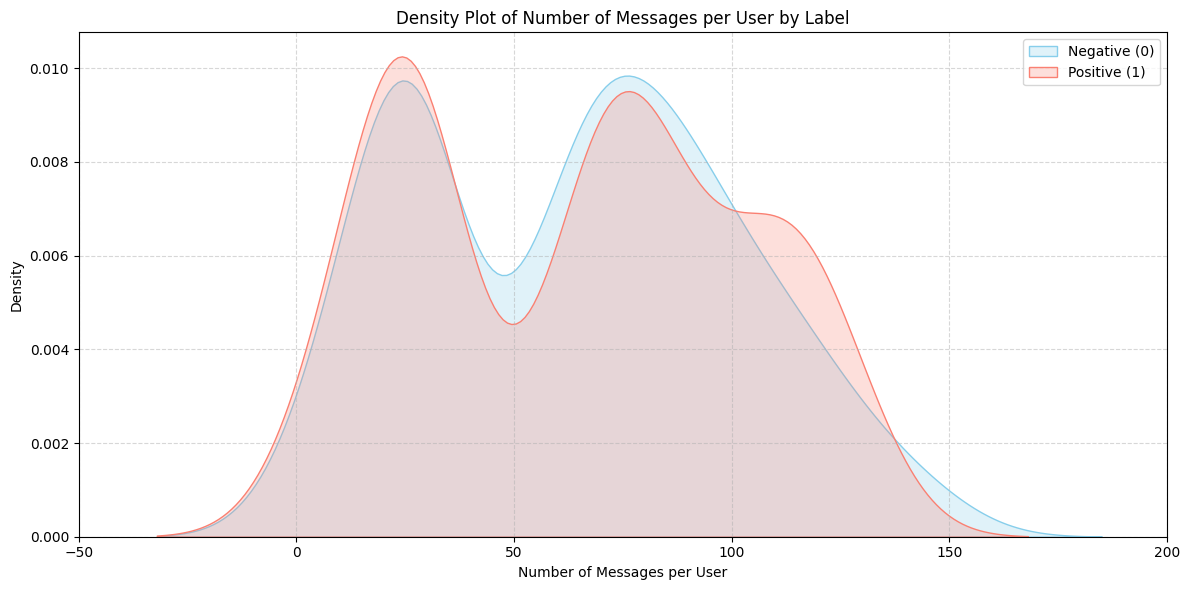

In [35]:
user_message_counts_0 = df[df['label'] == 0].groupby('user').size().reset_index(name='message_count')
user_message_counts_1 = df[df['label'] == 1].groupby('user').size().reset_index(name='message_count')

plt.figure(figsize=(12, 6))

sns.kdeplot(user_message_counts_0['message_count'], fill=True, label='Negative (0)', common_norm=False, color=color_0) #, clip_on=True, clip=(0, None))
sns.kdeplot(user_message_counts_1['message_count'], fill=True, label='Positive (1)', common_norm=False, color=color_1) #, clip_on=True, clip=(0, None))

plt.xlabel('Number of Messages per User')
plt.ylabel('Density')
plt.title('Density Plot of Number of Messages per User by Label')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.xlim(-50, 200) 
plt.tight_layout()
plt.show()

## Task 2

**Type of Addiction Detection**: As all users are at risk (low or high), no matter the decision, for all of them the model should identify the specific type of addiction associated with the disorder..The available labels are Betting, Online Gaming, Trading, and Lootboxes.

### Annotations

In [36]:
annotation_path = data_path / "task2" / "train" / "gold_task2.txt"
df = pd.read_csv(annotation_path)
annotation_users = df.Subject.values
df.head()

labels_df = df.rename(columns={"Subject": "user", "Type": "label"})
labels_df.head()

,user,label
0,user1036,betting
1,user1037,betting
2,user1150,betting
3,user124,betting
4,user1301,betting


In [37]:
labels_df.dtypes

user     object
label    object
dtype: object

In [38]:
print("INFO:")
print(f"INFO: total number of users {len(labels_df)}")
print(f"INFO: unique classes {labels_df.label.unique()}")
labels_df.describe()

INFO:
INFO: total number of users 350
INFO: unique classes ['betting' 'onlinegaming' 'trading' 'lootboxes']


,user,label
count,350,350
unique,350,4
top,user28667,trading
freq,1,135


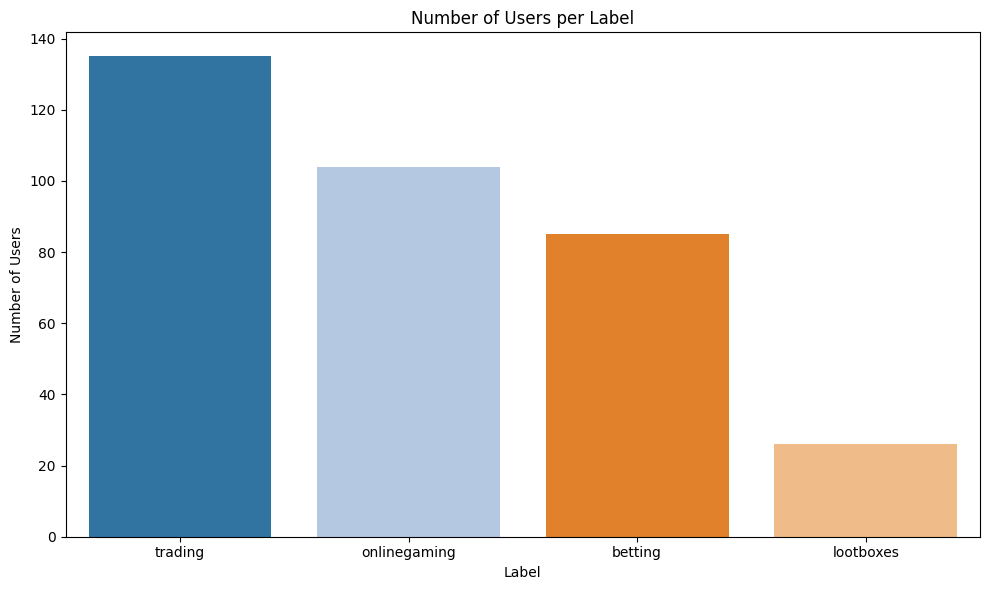

In [39]:
label_counts = labels_df['label'].value_counts()

label_counts_df = label_counts.reset_index()
label_counts_df.columns = ['label', 'num_users']

plt.figure(figsize=(10, 6))
sns.barplot(x='label', y='num_users', data=label_counts_df, palette='tab20', hue="label")
plt.xlabel('Label')
plt.ylabel('Number of Users')
plt.title('Number of Users per Label')
plt.tight_layout()
plt.show()

In [40]:
label_counts_df

,label,num_users
0,trading,135
1,onlinegaming,104
2,betting,85
3,lootboxes,26


### Messages

Dataset is the same from task1 ...

In [41]:
merged_df = all_messages_df.merge(labels_df, on="user", how="left")
merged_df.head()

,id_message,message,platform,user,label
0,60951539963,El canal del amigo se llama loco por el trading ?,Telegram,user10040,trading
1,16299019771,Hay vivo hoy ?,Telegram,user10040,trading
2,34554847765,Eos alguien lo vio ?,Telegram,user10040,trading
3,84775152095,A que hora es el vivo ?,Telegram,user10040,trading
4,22627629888,No arranca vet,Telegram,user10040,trading


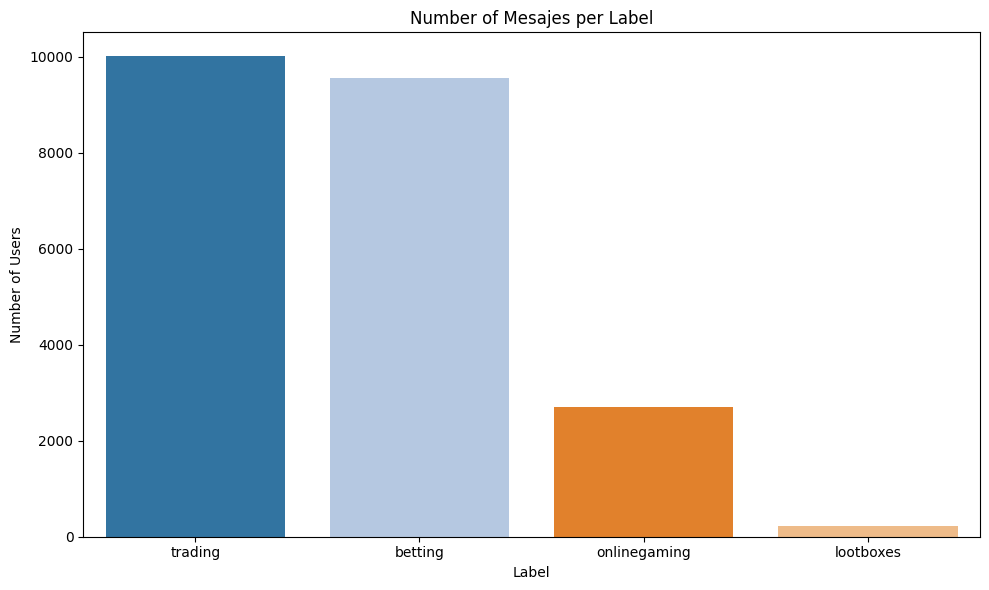

In [42]:
merged_counts = merged_df['label'].value_counts()

merged_counts = merged_counts.reset_index()
merged_counts.columns = ['label', 'num_users']

plt.figure(figsize=(10, 6))
sns.barplot(x='label', y='num_users', data=merged_counts, palette='tab20', hue="label")
plt.xlabel('Label')
plt.ylabel('Number of Users')
plt.title('Number of Mesajes per Label')
plt.tight_layout()
plt.show()

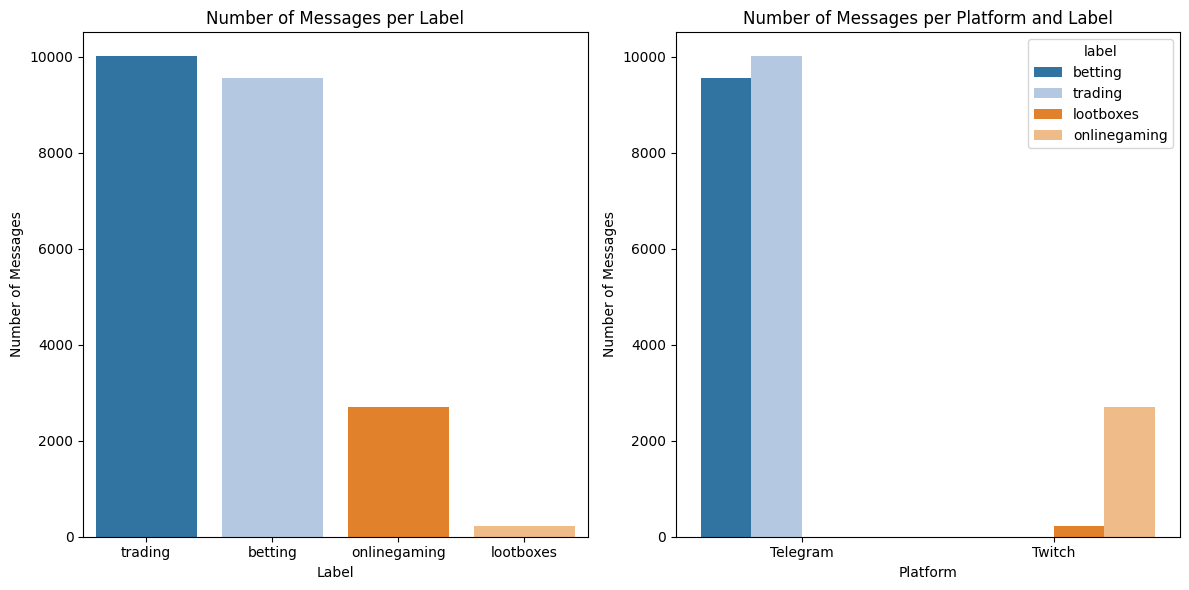

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 2 rows, 1 column

# --- First Subplot: Messages per Label ---
merged_counts = merged_df['label'].value_counts()
merged_counts = merged_counts.reset_index()
merged_counts.columns = ['label', 'num_messages']  # Changed num_users to num_messages

sns.barplot(ax=axes[0], x='label', y='num_messages', data=merged_counts, palette='tab20',
            hue="label", dodge=False)  # Use axes[0] to specify the subplot
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Number of Messages')  # Changed to Number of Messages
axes[0].set_title('Number of Messages per Label')
axes[0].tick_params(axis='x', rotation=0)  # Rotate x-axis labels



# --- Second Subplot: Messages per Platform and Label ---
platform_label_counts = merged_df.groupby(['platform', 'label']).size().reset_index(name='count')

sns.barplot(ax=axes[1], x='platform', y='count', hue='label', data=platform_label_counts, palette='tab20')
axes[1].set_xlabel('Platform')
axes[1].set_ylabel('Number of Messages')
axes[1].set_title('Number of Messages per Platform and Label')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

In [44]:
platform_label_counts

,platform,label,count
0,Telegram,betting,9566
1,Telegram,trading,10007
2,Twitch,lootboxes,215
3,Twitch,onlinegaming,2703


- can we derive from this that `betting` and `trading` messages only occur on *Telegram*?
- can we derive from this that `lootboxes` and `onlinegaming` messages only occur on *Twitch*?

Most likely we cannot but special attetion must be paid to this unbalanced in the dataset.

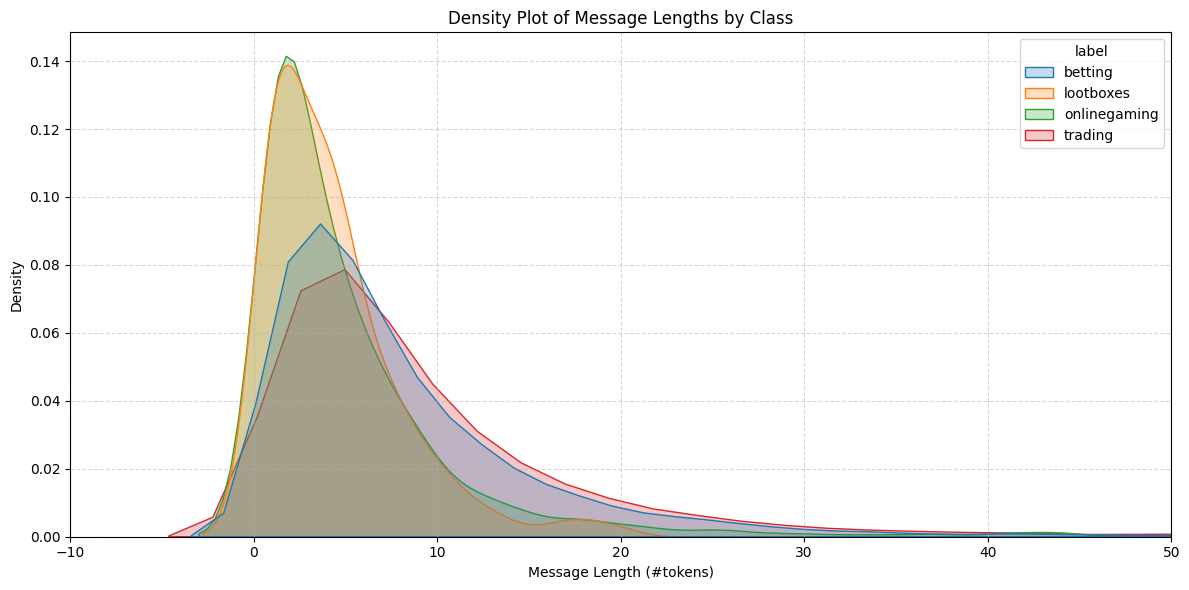

In [45]:
df = merged_df.copy()

# Calculate message lengths
df['message_length'] = df['message'].str.split().str.len()

df['label'] = df['label'].astype('category')

plt.figure(figsize=(12, 6))

# Create plot
ax = sns.kdeplot(data=df, x='message_length', hue='label', fill=True, common_norm=False, palette="tab10", legend=True)


plt.xlabel('Message Length (#tokens)')
plt.ylabel('Density')
plt.title('Density Plot of Message Lengths by Class')
plt.xlim(-10, 50)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## Conclusions

* **Dataset Balance (Task 1):** The initial binary classification dataset (positive/negative) is well-balanced, with a near 50/50 split between positive and negative samples across 350 users.
* **Platform Imbalance (Task 1):** The data is heavily skewed towards Telegram, with significantly more messages compared to Twitch. This imbalance should be considered when building models. While both platforms contain positive samples, Telegram contributes substantially more.
* **User Messaging Activity (Task 1):**  Users can be broadly grouped into three categories based on message frequency: those with fewer than 20 messages, those with 20-60 messages, and those with more than 60 messages. The distribution of healthy and positive users appears balanced within the dataset.
* **Multi-Class Imbalance (Task 2):** The multi-class classification task (betting, onlinegaming, trading, lootboxes) exhibits significant class imbalance at the user level. Trading has the most users, followed by onlinegaming, betting, and lastly, lootboxes.
* **Platform-Class Correlation (Task 2):** There's a strong association between platform and class label. Betting and Trading messages are primarily found on Telegram, while Lootboxes and Onlinegaming messages are primarily found on Twitch.
* **Caution Regarding Platform-Class Exclusivity (Task 2):**  While the data suggests a strong platform-class correlation, it is crucial to avoid assuming these categories are *exclusively* present on their respective platforms without further investigation. The observed imbalance necessitates careful handling during model training to avoid bias and ensure generalization. The model might learn to simply predict based on the platform rather than the content of the message.